# Analysing the Distributions of Edit-Session Lengths
<h3>(by platform; for visual-editor powered interfaces)</h3>
<hr>

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**<br>
**Last updated on 19 July 2023**

[TASK: T338634](https://phabricator.wikimedia.org/T338634)

# Contents

1. [Introduction](#Introduction)
2. [Summary](#Summary)
3. [Data Gathering](#Data-Gathering)
4. [Histograms](#Histograms)
5. [Appendix](#Appendix)

# Introduction
The purpose of this analysis is to help the Editing team understand the distribution of edit session lengths for visual-editor-powered editing interfaces, across platforms. The findings are intended to help the editing team inform their decision for how long should the edit stash [TTL](https://en.wikipedia.org/wiki/Time_to_live) be set to ([T320536](https://phabricator.wikimedia.org/T320536)).

The learning objectives are to understand the distributions of edit sessions lengths (by platform and editing interface):
- for edits that were initiated and successfully saved
- for edits that were initiated and aborted

# Summary

The data was gathered from the event logs of [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/current.yaml). 90-days of [unsanitized event data](https://wikitech.wikimedia.org/wiki/Analytics/Event_Sanitization) preceding 19 July 2023 was considered for the analysis. The length of an edit session is calculated as a difference between the max and min of `client_dt` for a given `editing_session_id`. The data was analysed by desktop and mobile (phone) platforms, and by editing interfaces - visual editor and wikitext-2017 (a mode within visual editor).

There were sessions with 0-duration. Among successfully saved edits, the number of 0-duration sessions is insignificant (0.02% of ~4.8 million sessions) - inclusion or exclusion of these don't have any effect on the distributions until the 99th percentile. However, among aborted edits, the number of 0-duration sessions is 1.3% of ~16.9 million sessions, and including them affects the distributions beyond the 75th percentile by bringing down the session lengths. For the analysis, 0-duration sessions were not considered, however, they are included in the [appendix](#Appendix) for reference.

In [63]:
warnings.filterwarnings('ignore')

print(bold, 'Time to save (excl. 0-duration sessions)', end)
display_h({
    'Desktop (visual editor)': quantiles(completed, 'desktop', 'visualeditor', 'exclude'),
    'Desktop (wikitext-2017 editor)': quantiles(completed, 'desktop', 'wikitext-2017', 'exclude'),
    'Phone (visual editor)': quantiles(completed, 'phone', 'visualeditor', 'exclude'),
    'Phone (wikitext-2017 editor)': quantiles(completed, 'phone', 'wikitext-2017', 'exclude')
})

warnings.filterwarnings('ignore')

print(bold, 'Time to abort (excl. 0-duration sessions)', end)
display_h({
    'Desktop (visual editor)': quantiles(aborted, 'desktop', 'visualeditor', 'exclude'),
    'Desktop (wikitext-2017 editor)': quantiles(aborted, 'desktop', 'wikitext-2017', 'exclude'),
    'Phone (visual editor)': quantiles(aborted, 'phone', 'visualeditor', 'exclude'),
    'Phone (wikitext-2017 editor)': quantiles(aborted, 'phone', 'wikitext-2017', 'exclude')
})

 Time to save (excl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,16
25th,32
50th,83
75th,273
90th,881
99th,6896
,time (in seconds)
percentile,
10th,10


 Time to abort (excl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,2
25th,3
50th,6
75th,15
90th,81
99th,4403
,time (in seconds)
percentile,
10th,2


# Data-Gathering

## imports

In [2]:
import pandas as pd
import numpy as np
import wmfdata as wmf

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

from datetime import timedelta, datetime
import warnings

from IPython.display import display_html

In [3]:
pd.options.display.max_columns = None
bold = '\033[1m'
end = '\033[0m'

## spark_session

In [4]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [5]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/19 09:10:02 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/07/19 09:10:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [5]:
# ig_warn()
# spark_session = wmf.spark.create_session(type='yarn-large')
spark_session

In [6]:
spark_session.sparkContext.setLogLevel("ERROR")

## query

In [ ]:
%%time

query = """
WITH
    sessions AS (
        SELECT
            event.editing_session_id AS session_id,
            event.platform,
            event.page_ns,
            event.user_class,
            event.editor_interface,
            SUM(CAST(event.action = 'init' AS INT)) AS init_count,
            SUM(CAST(event.action = 'saveSuccess' AS INT)) AS save_success_count,
            SUM(CAST(event.action = 'abort' AS INT)) AS abort_count,
            MAX(client_dt) AS max_ts,
            MIN(client_dt) AS min_ts
        FROM
            event.editattemptstep
        WHERE
            event.editor_interface IN ('visualeditor', 'wikitext-2017') AND
            year = {YEAR} AND month = {MONTH}
        GROUP BY
            event.editing_session_id,
            event.platform,
            event.page_ns,
            event.user_class,
            event.editor_interface
    )

SELECT *
FROM sessions
WHERE
    init_count > 0 AND
    ((save_success_count > 0) OR 
     (abort_count > 0))
"""

# query month-wise as querying all month is leading to Spark OutOfMemory Error
sessions = pd.DataFrame()
end_time = datetime.now() - timedelta(days=1)
start_time = datetime.now() - timedelta(days=90)

for month in pd.period_range(str(start_time.date()), str(end_time.date()), freq='M'):
    monthly_records = wmf.spark.run(query.format(YEAR=month.year, MONTH=month.month))
    sessions = pd.concat([sessions, monthly_records], ignore_index=True)

In [17]:
# set explicit classes, as null values (i.e. user) are not displayed in Pandas count outputs

def uclass_sort(user):
    if user == 'IP':
        return 'anon'
    elif user == 'bot':
        return 'bot'
    else:
        return 'user'
    
sessions['user_class'] = sessions['user_class'].apply(lambda x: uclass_sort(x))
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21980880 entries, 0 to 21980879
Data columns (total 10 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   session_id          object
 1   platform            object
 2   page_ns             int64 
 3   user_class          object
 4   editor_interface    object
 5   init_count          int64 
 6   save_success_count  int64 
 7   abort_count         int64 
 8   max_ts              object
 9   min_ts              object
dtypes: int64(4), object(6)
memory usage: 1.6+ GB


In [18]:
# save to parquet
parquet_file = 've_sessions_2023.parquet'
sessions.to_parquet(parquet_file, index=False)

In [19]:
sessions = pd.read_parquet(parquet_file)

In [ ]:
# format data types
sessions = (
    sessions
    .assign(
        min_ts=pd.to_datetime(sessions['min_ts'], utc=True),
        max_ts=pd.to_datetime(sessions['max_ts'], utc=True),
        platform=pd.Categorical(sessions['platform']),
        user_class=pd.Categorical(sessions['user_class']),
        editor_interface=pd.Categorical(sessions['editor_interface']))
    .assign(
        duration=lambda df: round((df["max_ts"] - df["min_ts"]).dt.total_seconds()).astype(int)))

sessions.head(3)

In [21]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21980880 entries, 0 to 21980879
Data columns (total 11 columns):
 #   Column              Dtype              
---  ------              -----              
 0   session_id          object             
 1   platform            category           
 2   page_ns             int64              
 3   user_class          category           
 4   editor_interface    category           
 5   init_count          int64              
 6   save_success_count  int64              
 7   abort_count         int64              
 8   max_ts              datetime64[ns, UTC]
 9   min_ts              datetime64[ns, UTC]
 10  duration            int64              
dtypes: category(3), datetime64[ns, UTC](2), int64(5), object(1)
memory usage: 1.4+ GB


In [22]:
# considering sessions only with either success or abort event, but not both
# sessions with both success and abort events may be erroneous events that need further analysis
completed = sessions.query("""(save_success_count >= 1) & (abort_count == 0)""")
print(f'successfuly completed sessions: {completed.shape[0]}')

aborted = sessions.query("""(abort_count >= 1) & (save_success_count == 0)""")
print(f'aborted sessions: {aborted.shape[0]}')

successfuly completed sessions: 4831581
aborted sessions: 16994617


Note: A summary of erroneous events such as sessions having both save and abort logs, having no inits, having no outcomes etc. has been provided in `data_qa.ipynb` notebook (in same repo)

## explore data
Note: 'platform' referers to edits performed through MobileFrontend (platform = 'phone') or not (platform = 'desktop').

### successfully completed sessions
<u>Summary:</u> Sessions with zero duration form a insignificant part of the overall number of successfully saved sessions (0.01%). Since excluding them will not result any substantial changes in the time to save distributions, we will be excluding them while plotting the histograms (for consistency with the aborted sessions).

In [23]:
print(bold, 'percentage of zero duration sessions (of all completed sessions)', end)
print(f'{round(completed.query("""duration == 0""").shape[0] / completed.shape[0] * 100, 2)}% (of {completed.shape[0]} completed sessions)')

 percentage of zero duration sessions (of all completed sessions) 
0.02% (of 4831581 completed sessions)


In [25]:
print(bold, 'median time to save for completed sessions, by platform and editor interface', end)
completed.groupby(['platform', 'editor_interface'])['duration'].apply(np.median)

 median time to save for completed sessions, by platform and editor interface 


platform  editor_interface
desktop   visualeditor        83.0
          wikitext-2017       52.0
phone     visualeditor        62.0
          wikitext-2017       80.0
Name: duration, dtype: float64

In [26]:
print(bold, 'median time to save for completed sessions, by platform and editor interface (excluding zero duration sessions)', end)
completed.query("""duration > 0""").groupby(['platform', 'editor_interface'])['duration'].apply(np.median)

 median time to save for completed sessions, by platform and editor interface (excluding zero duration sessions) 


platform  editor_interface
desktop   visualeditor        83.0
          wikitext-2017       52.0
phone     visualeditor        62.0
          wikitext-2017       80.0
Name: duration, dtype: float64

In [27]:
print(bold, 'frequency of sessions (saved) with duration as zero by platform, userclass, and editor interface', end)
completed.query("""duration == 0""")[['platform', 'editor_interface', 'user_class']].value_counts()

 frequency of sessions (saved) with duration as zero by platform, userclass, and editor interface 


platform  editor_interface  user_class
desktop   wikitext-2017     user          664
          visualeditor      user          156
phone     visualeditor      user           95
desktop   visualeditor      anon           11
phone     wikitext-2017     user            8
desktop   wikitext-2017     anon            7
phone     wikitext-2017     anon            4
          visualeditor      anon            2
dtype: int64

### aborted sessions
<u>Summary</u> Unlike for completed sessions, number of zero durations among the aborted sessions are not non-trivial. The median shifts down when the zero duration sessions are included. For plotting the histograms, we will be excluding the zero duration sessions, so as not to skew the results to imply less time taken.

In [28]:
print(bold, 'percentage of zero duration sessions (of all aborted sessions)', end)
print(f'{round(aborted.query("""duration == 0""").shape[0] / aborted.shape[0] * 100, 2)}% (of {aborted.shape[0]} aborted sessions)')

 percentage of zero duration sessions (of all aborted sessions) 
1.35% (of 16994617 aborted sessions)


In [29]:
print(bold, 'median time to abort, by platform and editor interface', end)
aborted.groupby(['platform', 'editor_interface'])['duration'].apply(np.median)

 median time to abort, by platform and editor interface 


platform  editor_interface
desktop   visualeditor         6.0
          wikitext-2017       10.0
phone     visualeditor        11.0
          wikitext-2017        1.0
Name: duration, dtype: float64

In [30]:
print(bold, 'median time to abort, by platform and editor interface (excluding zero duration sessions)', end)
aborted.query("""duration != 0""").groupby(['platform', 'editor_interface'])['duration'].apply(np.median)

 median time to abort, by platform and editor interface (excluding zero duration sessions) 


platform  editor_interface
desktop   visualeditor         6.0
          wikitext-2017       12.0
phone     visualeditor        11.0
          wikitext-2017        1.0
Name: duration, dtype: float64

In [31]:
print(bold, 'frequency of sessions (aborted) with duration as zero by platform, editor interface and userclass', end)
aborted.query("""duration == 0""")[['platform', 'editor_interface', 'user_class']].value_counts()

 frequency of sessions (aborted) with duration as zero by platform, editor interface and userclass 


platform  editor_interface  user_class
desktop   visualeditor      anon          80978
phone     wikitext-2017     anon          66726
desktop   wikitext-2017     anon          43433
phone     visualeditor      anon          13947
desktop   wikitext-2017     user          11624
          visualeditor      user           6760
phone     wikitext-2017     user           3639
          visualeditor      user           3102
dtype: int64

# Histograms

In [32]:
# the plotting function has been built upon a similar analysis from 2018
# https://github.com/wikimedia-research/2018-08-Editing-metrics-snapshots/blob/master/analysis.ipynb

def generate_hist(ax, source_frame, title, 
                  col='duration', 
                  ylabel='number of sessions', 
                  legend_loc='upper right', 
                  anchor_pos=(1.5, 1), 
                  treat_zeros='exclude'):
    
    frame = source_frame.copy()
    if treat_zeros == 'exclude':
        frame = frame[frame[col] > 0]
    elif treat_zeros == 'replace':
        frame[col] = frame[col].replace(0, 1)
    else:
        pass
    
    ax = sns.histplot(data=frame, 
                      x=col, 
                      log_scale=True,
                      bins = np.linspace(0, 4, 40), 
                      element='step',
                      color='#DAA520'
                 )
    
    def td_str(s):
        return str(timedelta(seconds=int(s)))
    
    x_ticks = [1, 10, 60, 10*60, 60*60]
    duration_ticks = FixedLocator(x_ticks)
    duration_fmt = FuncFormatter(lambda x, pos: td_str(x))
    
    lines = [
        ("10th percentile ({})", frame[col].quantile(0.1), "#FF0000"),
        ("50th percentile ({})", frame[col].median(), "#6B8E23"),
        ("90th percentile ({})", frame[col].quantile(0.9), "#0000FF")
    ]
    
    for label, pos, color in lines:
        ax.axvline(x=pos, color=color, label=label.format(td_str(pos)))
    
    ax.xaxis.set_major_locator(duration_ticks)
    ax.xaxis.set_major_formatter(duration_fmt)
    
    ax.set_title(title)
    ax.set_xlabel('time to save [%H:%M:%S] (log scale)')
    ax.set_ylabel(ylabel)
    
    ax.legend(loc=legend_loc, bbox_to_anchor=anchor_pos)

### successfully saved sessions

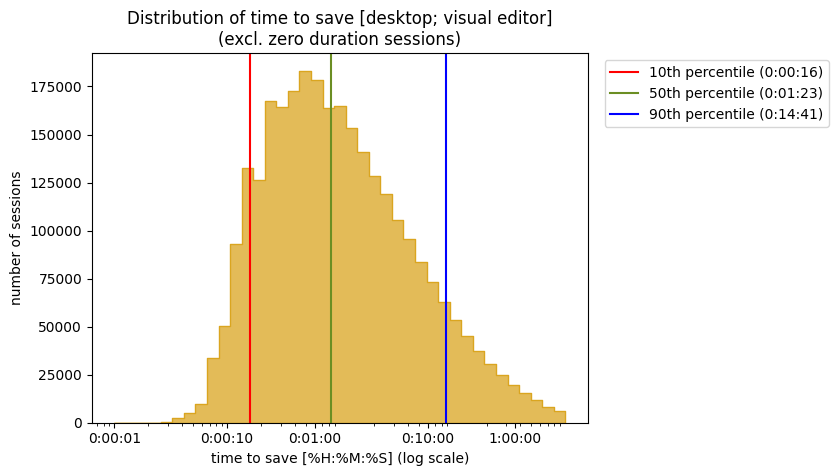

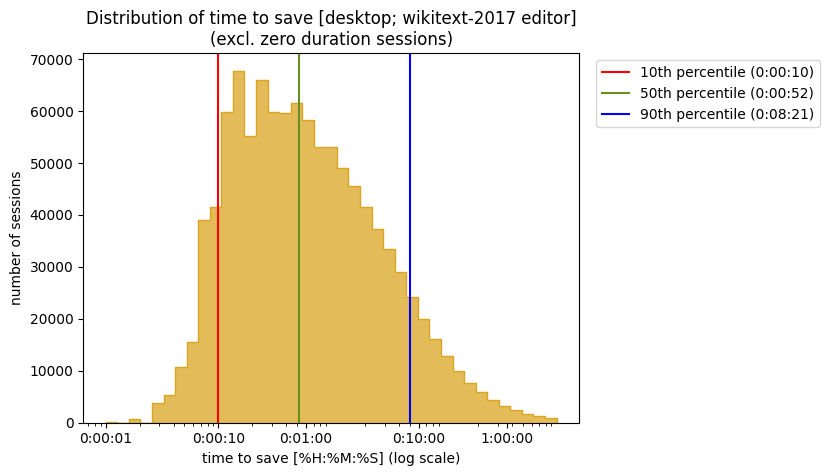

In [48]:
fig, ax = plt.subplots()
generate_hist(ax, completed.query("""(platform == 'desktop') & (editor_interface == 'visualeditor')"""), 
              title='Distribution of time to save [desktop; visual editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

fig, ax = plt.subplots()
generate_hist(ax, completed.query("""(platform == 'desktop') & (editor_interface == 'wikitext-2017')"""), 
              title='Distribution of time to save [desktop; wikitext-2017 editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

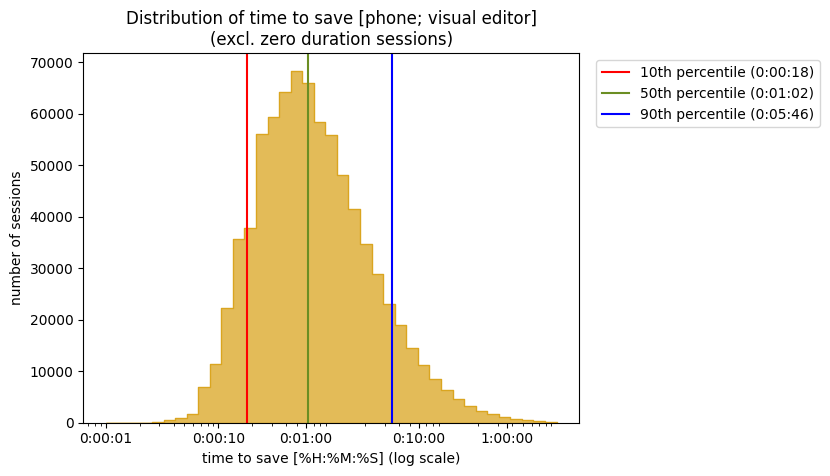

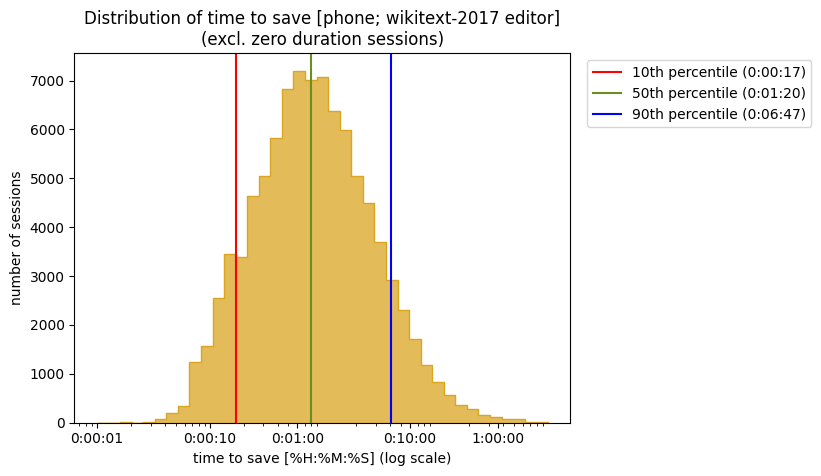

In [49]:
fig, ax = plt.subplots()
generate_hist(ax, completed.query("""(platform == 'phone') & (editor_interface == 'visualeditor')"""), 
              title='Distribution of time to save [phone; visual editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

fig, ax = plt.subplots()
generate_hist(ax, completed.query("""(platform == 'phone') & (editor_interface == 'wikitext-2017')"""), 
              title='Distribution of time to save [phone; wikitext-2017 editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

### aborted sessions

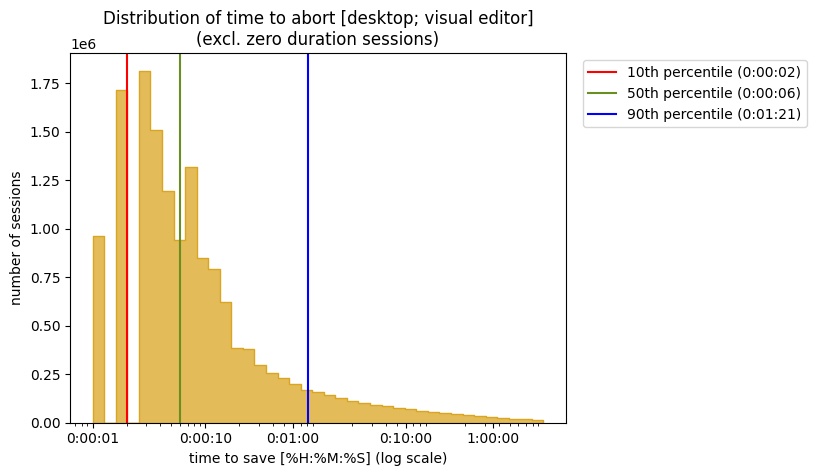

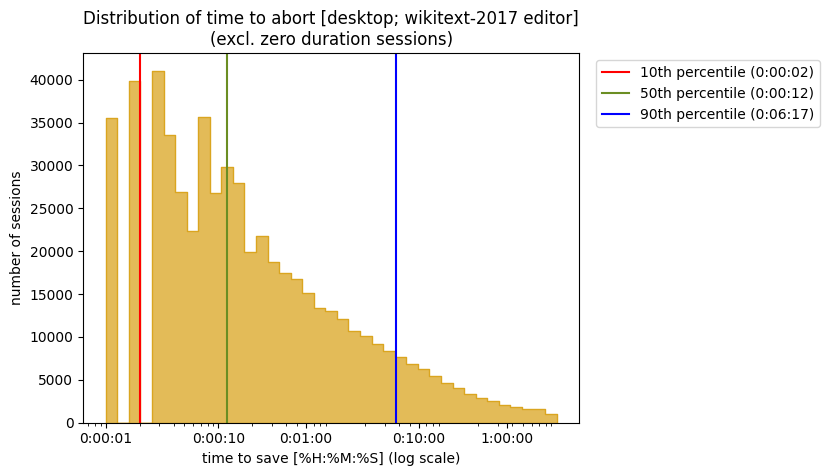

In [53]:
fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""(platform == 'desktop') & (editor_interface == 'visualeditor')"""), 
              title='Distribution of time to abort [desktop; visual editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""(platform == 'desktop') & (editor_interface == 'wikitext-2017')"""), 
              title='Distribution of time to abort [desktop; wikitext-2017 editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

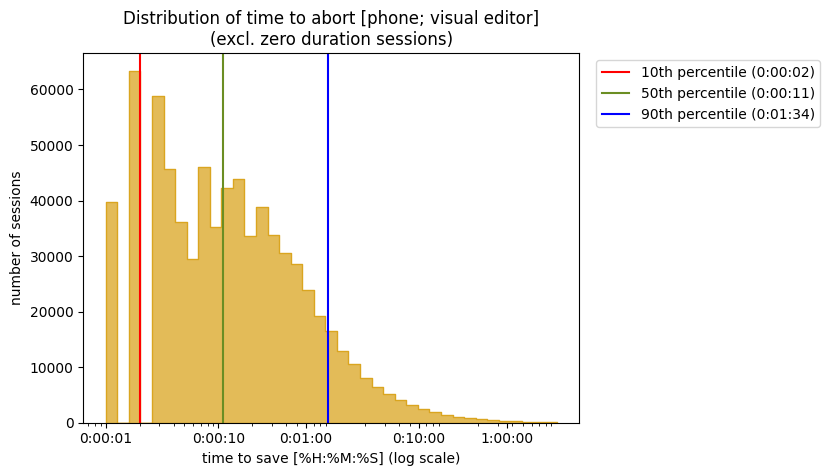

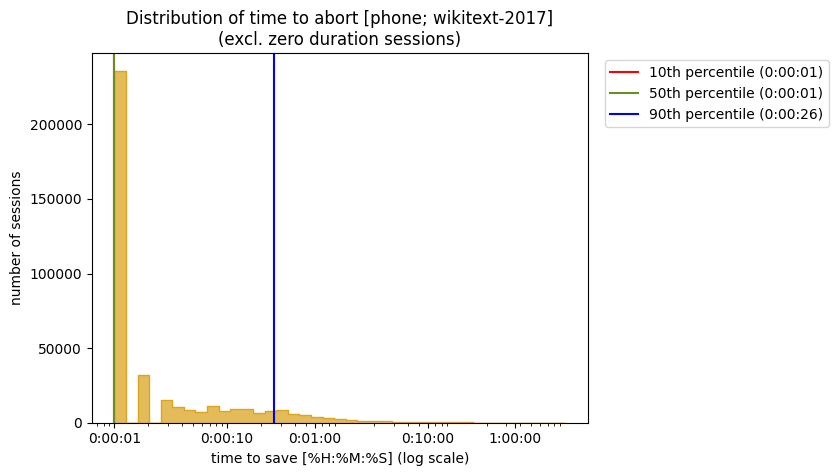

In [52]:
fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""(platform == 'phone') & (editor_interface == 'visualeditor')"""), 
              title='Distribution of time to abort [phone; visual editor]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

fig, ax = plt.subplots()
generate_hist(ax, aborted.query("""(platform == 'phone') & (editor_interface == 'wikitext-2017')"""), 
              title='Distribution of time to abort [phone; wikitext-2017]\n(excl. zero duration sessions)', 
              treat_zeros='exclude')

# Appendix

In [59]:
def quantiles(source_frame, platform, interface, treat_zeros, col='duration'):
    frame = source_frame.query("""(platform == @platform) & (editor_interface == @interface)""")
    
    if treat_zeros == 'exclude':
        frame = frame[frame[col] > 0]
    elif treat_zeros == 'replace':
        frame[col] = frame[col].replace(0, 1)
    else:
        pass
    
    qdict = {
        '10th': frame[col].quantile(0.1),
        '25th': frame[col].quantile(0.25),
        '50th': frame[col].quantile(0.5),
        '75th': frame[col].quantile(0.75),
        '90th': frame[col].quantile(0.9),
        '99th': frame[col].quantile(0.99)
    }
    
    df = pd.DataFrame(qdict.values(),
                      index=qdict.keys(),
                      columns=['time (in seconds)'])
    
    df = df.astype({'time (in seconds)': int})
    df.index.name = 'percentile'
    
    return df

In [56]:
def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

In [62]:
warnings.filterwarnings('ignore')

print(bold, 'Time to save (incl. 0-duration sessions)', end)
display_h({
    'Desktop (visual editor)': quantiles(completed, 'desktop', 'visualeditor', None),
    'Desktop (wikitext-2017 editor)': quantiles(completed, 'desktop', 'wikitext-2017', None),
    'Phone (visual editor)': quantiles(completed, 'phone', 'visualeditor', None),
    'Phone (wikitext-2017 editor)': quantiles(completed, 'phone', 'wikitext-2017', None)
})

warnings.filterwarnings('ignore')

print(bold, 'Time to abort (incl. 0-duration sessions)', end)
display_h({
    'Desktop (visual editor)': quantiles(aborted, 'desktop', 'visualeditor', None),
    'Desktop (wikitext-2017 editor)': quantiles(aborted, 'desktop', 'wikitext-2017', None),
    'Phone (visual editor)': quantiles(aborted, 'phone', 'visualeditor', None),
    'Phone (wikitext-2017 editor)': quantiles(aborted, 'phone', 'wikitext-2017', None)
})

 Time to save (incl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,16
25th,32
50th,83
75th,273
90th,881
99th,6895
,time (in seconds)
percentile,
10th,10


 Time to abort (incl. 0-duration sessions) 


,time (in seconds)
percentile,
10th,2
25th,3
50th,6
75th,15
90th,80
99th,4368
,time (in seconds)
percentile,
10th,1
